In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
from pathlib import Path

PLY_PATH = str(Path().joinpath("data", "fragment.ply"))
print(PLY_PATH)

data/fragment.ply


In [72]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt


def show_image_from_ndarray(image_array):
    if (len(image_array.shape) < 3) or (image_array.shape[-1] == 1):
        plt.imshow(image_array)
        plt.axis("off")
    else:
        plt.imshow(image_array)
        plt.axis("off")


def generate_view_image_from_pcd(pcd: o3d.geometry.PointCloud) -> np.ndarray:
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False)
    vis.add_geometry(pcd)
    image = np.asarray(vis.capture_screen_float_buffer(True))
    return image


# Load point cloud data

In [73]:
import copy

pcd = o3d.io.read_point_cloud(PLY_PATH)
pcd_cloned = copy.deepcopy(pcd)
print(pcd)


PointCloud with 196133 points.


# Execute DBSCAN(open3d)

DBSCAN (Open3D-based):
Elapsed: 0.8044991493225098
results of np.unique(labels): 
	labels: [-1  0  1  2  3  4] 
	counts: [    40   5965  25192 164860     66     10]
point cloud has 5 clusters


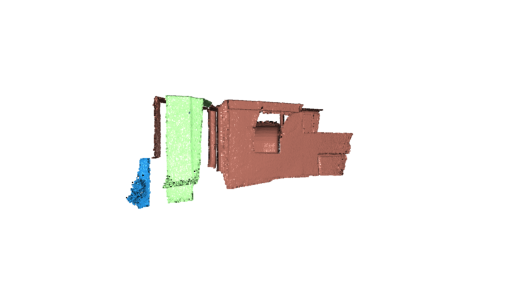

In [74]:
import time

print("DBSCAN (Open3D-based):")

start = time.time()
res = pcd.cluster_dbscan(eps=0.025, min_points=10, print_progress=False)
end = time.time()
print(f"Elapsed: {end-start}")

labels = np.array(res)
label_unique, label_counts = np.unique(labels, return_counts=True)
print(f"results of np.unique(labels): \n\tlabels: {label_unique} \n\tcounts: {label_counts}")

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

image = generate_view_image_from_pcd(pcd)
show_image_from_ndarray(image)

# Execute DBSCAN (fast parallel DBSCAN)

DBSCAN ("dbscan_python"-based):
Elapsed: 0.06848359107971191
results of np.unique(labels): 
	labels: [-1  0  1  2  3  4] 
	counts: [    40   5965  25192 164860     66     10]
[ True  True  True ...  True  True  True]
point cloud has 5 clusters


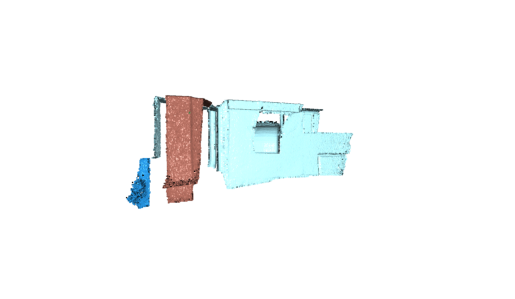

In [75]:
from dbscan import DBSCAN

print("DBSCAN (\"dbscan_python\"-based):")

pcd_np = np.asarray(pcd.points)

start = time.time()
labels_another, core_samples_mask = DBSCAN(pcd_np, eps=0.025, min_samples=10)
end = time.time()
print(f"Elapsed: {end-start}")

print(f"results of np.unique(labels): \n\tlabels: {label_unique} \n\tcounts: {label_counts}")
print(core_samples_mask)

max_label_another = labels_another.max()
print(f"point cloud has {max_label_another + 1} clusters")

colors = plt.get_cmap("tab20")(labels_another / (max_label_another if max_label_another > 0 else 1))
colors[labels_another < 0] = 0
pcd_cloned.colors = o3d.utility.Vector3dVector(colors[:, :3])
image = generate_view_image_from_pcd(pcd_cloned)
show_image_from_ndarray(image)
